# Predictive Ordering LSTM

---

This notebook contains the code of LSTM model to forecast the sales of the product.

---

In [25]:
import tensorflow as tf
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.8.0


## Loading the dataset

In [26]:
drive.mount("/content/gdrive")

dataset = pd.read_csv('gdrive/My Drive/PreprocessedOrders.csv', index_col='Period')
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Sales1,Sales2,Sales3,Sales4,Sales5,Sales6
Period,,,,,,
0,27,66,72,55,85,18
1,26,68,72,77,77,14
2,11,72,76,73,76,1
3,31,68,66,71,97,12
4,18,65,73,74,64,12


## Initialisation of variables

In [27]:
rows = len(dataset)
dataset = dataset.to_numpy()
time = np.arange(rows, dtype="float32")
time_train = time
dataset_train = dataset
max_value = 100000

## Dataset Visualisation

In [28]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

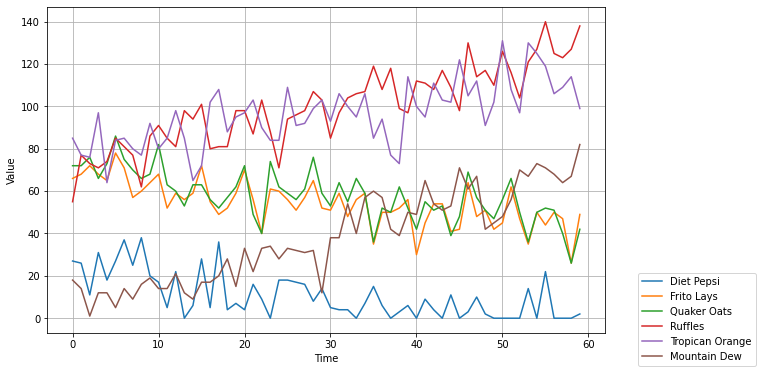

In [29]:
shortProductNames = ["Diet Pepsi", "Frito Lays", "Quaker Oats", "Ruffles", "Tropican Orange", "Mountain Dew"]
plt.figure(figsize=(10, 6))
plot_series(time_train, dataset_train)
plt.legend(shortProductNames, loc="upper left", bbox_to_anchor=(1.05, 0.0, 0.3, 0.2))
plt.show()

## Creating LSTM Model

In [30]:
""" Divide the datasets into batches """
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 12

train_set = windowed_dataset(dataset_train, window_size, batch_size=12, shuffle_buffer=12)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 6]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(6),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)


### Compiling the model

In [32]:
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])

In [33]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
4/4 [==============================] - 8s 30ms/step - loss: 75.3367 - mae: 75.8340 - lr: 1.0000e-08
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 75.2583 - mae: 75.7556 - lr: 1.1220e-08
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 75.1372 - mae: 75.6346 - lr: 1.2589e-08
Epoch 4/100
4/4 [==============================] - 0s 21ms/step - loss: 74.9569 - mae: 75.4546 - lr: 1.4125e-08
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 74.7455 - mae: 75.2432 - lr: 1.5849e-08
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 74.4783 - mae: 74.9759 - lr: 1.7783e-08
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 74.1671 - mae: 74.6648 - lr: 1.9953e-08
Epoch 8/100
4/4 [==============================] - 0s 20ms/step - loss: 73.8089 - mae: 74.3064 - lr: 2.2387e-08
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 73.4331 - mae: 73.9310 - lr: 2.5

Finding the best learning rate

(1e-08, 0.1, 0.0, 30.0)

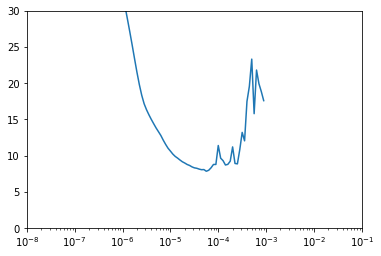

In [34]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 30])

Compiling the model with the optimized learning rate

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
batch_size = 12
train_set = windowed_dataset(dataset_train, window_size, batch_size, 12)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500)

Epoch 1/500
4/4 [==============================] - 7s 29ms/step - loss: 22.3073 - mae: 22.8039
Epoch 2/500
4/4 [==============================] - 0s 21ms/step - loss: 10.3753 - mae: 10.8658
Epoch 3/500
4/4 [==============================] - 0s 30ms/step - loss: 13.1908 - mae: 13.6829
Epoch 4/500
4/4 [==============================] - 0s 20ms/step - loss: 10.7478 - mae: 11.2397
Epoch 5/500
4/4 [==============================] - 0s 20ms/step - loss: 10.8062 - mae: 11.2966
Epoch 6/500
4/4 [==============================] - 0s 19ms/step - loss: 8.2691 - mae: 8.7583
Epoch 7/500
4/4 [==============================] - 0s 20ms/step - loss: 9.0995 - mae: 9.5908
Epoch 8/500
4/4 [==============================] - 0s 19ms/step - loss: 9.4275 - mae: 9.9158
Epoch 9/500
4/4 [==============================] - 0s 20ms/step - loss: 8.9842 - mae: 9.4737
Epoch 10/500
4/4 [==============================] - 0s 18ms/step - loss: 7.4510 - mae: 7.9378
Epoch 11/500
4/4 [==============================] - 0s 24ms

## Model Summary

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          992       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, None, 6)           390       
                                                                 
 lambda (Lambda)             (None, None, 6)           0         
                                                                 
Total params: 42,854
Trainable params: 42,854
Non-traina

## Validating the model

In [37]:
# construction of test data
(dataset_rows, dataset_cols) = dataset.shape
index_from = int(0.8 * dataset_rows)
time_validate = time[index_from:]
time_train = time[:index_from]
dataset_valid = dataset[index_from:]
test_input_data = dataset[index_from - 1: dataset_rows-1]
(dataset_valid_rows, dataset_valid_cols) = dataset_valid.shape
test_input_data = test_input_data.reshape(1, dataset_valid_rows, dataset_valid_cols)
result = model.predict(test_input_data).reshape(dataset_valid_rows, dataset_valid_cols).astype(int)
result = np.clip(result, 0, max_value)

### Output Visualisation

In [38]:
from sklearn.metrics import mean_absolute_error as mae

In [39]:
def SMAPE(actual, predicted):
  (rows, cols) = actual.shape
  updated_actual = actual
  updated_predicted = predicted

  model_error = 0

  for row in range(rows):
    for col in range(cols):
      if actual[row][col] == predicted[row][col] and actual[row][col] == 0:
          updated_actual[row][col] = 1
          updated_predicted[row][col] = 1
    
  for col in range(cols):
    model_error = model_error + round(np.mean(np.abs(updated_predicted[:, col] - updated_actual[:, col]) / ((np.abs(updated_predicted[:, col]) + np.abs(updated_actual[:, col]))/2))*100, 2)
  return model_error/cols

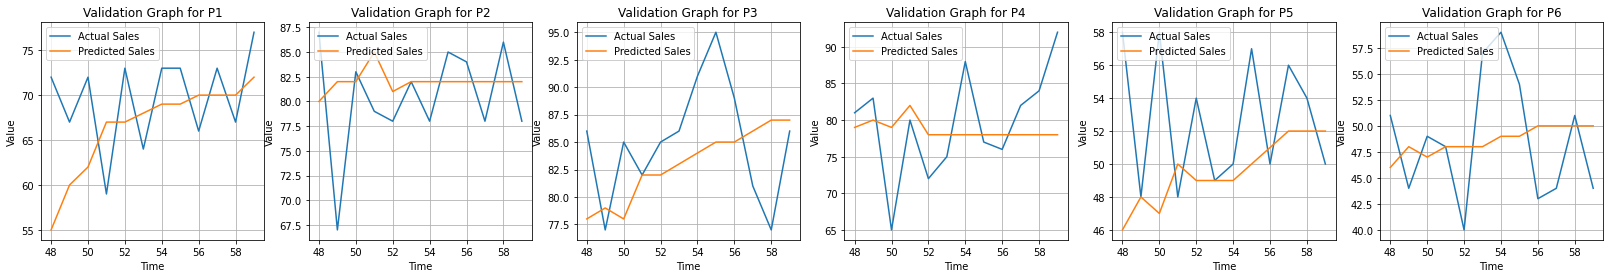

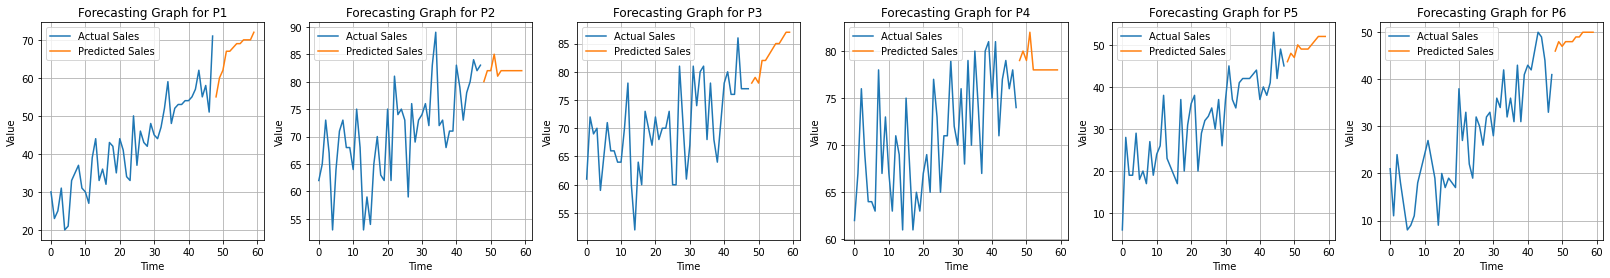

SMAPE error for the model is: 7.698333


In [40]:
(_, products) = dataset_valid.shape
plt.figure(figsize=(28, 4))
for product in range(products):
      train_data = dataset_train[:index_from]
      plt.subplot(1, 6, product+1)
      plot_series(time_validate, dataset_valid[:, product])
      plot_series(time_validate, result[:, product])
      plt.title("Validation Graph for P%d" %(product + 1))
      plt.legend(["Actual Sales", "Predicted Sales"], loc ="upper left")
plt.show()
plt.figure(figsize=(28, 4))
for product in range(products):
      plt.subplot(1, 6, product+1)
      plot_series(time_train, train_data[:, product])
      plot_series(time_validate, result[:, product])
      plt.title("Forecasting Graph for P%d" %(product + 1))
      plt.legend(["Actual Sales", "Predicted Sales"], loc ="upper left")
plt.show()

model_smape = SMAPE(dataset_valid, result)
print("SMAPE error for the model is: %f"  %(model_smape))

###Predicting the sales for the next period

In [41]:
duration = 1
(dataset_rows, dataset_cols) = dataset.shape
test_instance = dataset[dataset_rows - duration:]
test_instance = test_instance.reshape(1, duration, dataset_cols)
output = model.predict(test_instance).reshape(duration, dataset_cols).astype(int)
output = np.clip(output, 0, max_value)

Printing the next sales values

In [42]:
output

array([[59, 64, 67, 63, 34, 32]])